# Project overview
TL;DR: predict **magnitude** of z-component of electric field intensity in the H plane of arbitrary Hertzian dipole configurations using neural networks (primarily unet). 

## Simplyifying assumptions
For a first experiment, assume:
- All current sources are Hertzian dipoles of equal magnitude and phase
- The sources all have the same constant frequency
- The medium is a vacuum

### Concrete assumptions for 1st experiment
- Randomly use between 3 and 12 sources
- Make the current equal in all of them, as 1.0 MEEP units.
- Use freq-domain solver
- Get |E_z| in a region around the dipoles, surrounded by PML. 
- Render |E_z| as a black and white image, normalized to 1.0 maximum in MEEP units. 
- Predict |E_z| as a UNET image generation task, taking in 2D image of one-hot encoded sources (if pixel contains a source, it is white. Otherwise it is black).
    - Predict black-and-white 2D image output, which will be in scale of 0 to 1.0, allowing us to convet it to SI units if necessary. 
    - Use resnet18 to start with


## Install requirements

In [0]:
!pip install Pillow --upgrade

     |████████████████████████████████| 2.1MB 5.1MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


In [0]:
!pip install git+https://github.com/fastai/fastai2

  Cloning https://github.com/fastai/fastai2 to /tmp/pip-req-build-b7ibcypf
  Running command git clone -q https://github.com/fastai/fastai2 /tmp/pip-req-build-b7ibcypf
  Created wheel for fastai2: filename=fastai2-0.0.4-cp36-none-any.whl size=172318 sha256=e45ac785a45437d3608d35a07ee81c3f999821e779a09c10fc39a7df7cbdc18a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ujq08tm_/wheels/a1/59/9a/50335b36924b827e29d5f40b41fc3a008cc1f30dd80e560dfd
Successfully built fastai2


In [0]:
!7z x train.7z train


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 10679172 bytes (11 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 10679172
Headers Size = 15723
Method = LZMA2:12m
Solid = +
Blocks = 1

  0%     29% 3       48% 393 - train/labels/train_0390_label.png                                             68% 394 - train/labels/train_0391_label.png                                             97% 784 - train/labels/train_0781_label.png                                            

## Training unet 
Here we train a unet to, given a black image with white pixels precisely where hertzian dipoles exist, to produce the z-directed electric field magnitude (near field) due to the source distribution.

In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *
import os, time

path = Path('train')
path_labels = path/'labels'
path_x = path/'x'

In [0]:
class PILImageGrayCM(PILImageBW):
    _show_args = {'cmap': 'gray'} # use matplotlib's `gray` scale when showing image
    
class PILImageRGB(PILImage):
    _open_args = {'mode': 'RGB'} # convert to 3-channel RGB image when loading image

dblock = DataBlock(blocks=(
                ImageBlock(cls=PILImageRGB), # defines the input type
                ImageBlock(cls=PILImageGrayCM) # defines the output type
                ),
                get_items=get_image_files, # fastai function to return image files in a given path
                get_y=lambda x: path_labels/f'{x.stem}_label.png', # defines how label image name is derived from input image name `x`
                splitter=RandomSplitter(seed=112)) # how to make the train/validation/test split

In [0]:
bs = 16

# this will add the set of square dihedral transforms
batch_tfms = aug_transforms(do_flip=True, flip_vert=True, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0) 
# create databunch from datablock
dbunch = dblock.databunch(path_x, # give path of input data on disk
                        bs=bs, # and batch size
                        path=path, # path where models/config is to be saved
                        batch_tfms=[*batch_tfms]) #Normalize.from_stats(mean,std)])         
dbunch.c = 1 # indicate that image output should only have 1 channe
print(len(dbunch.train_ds))

800


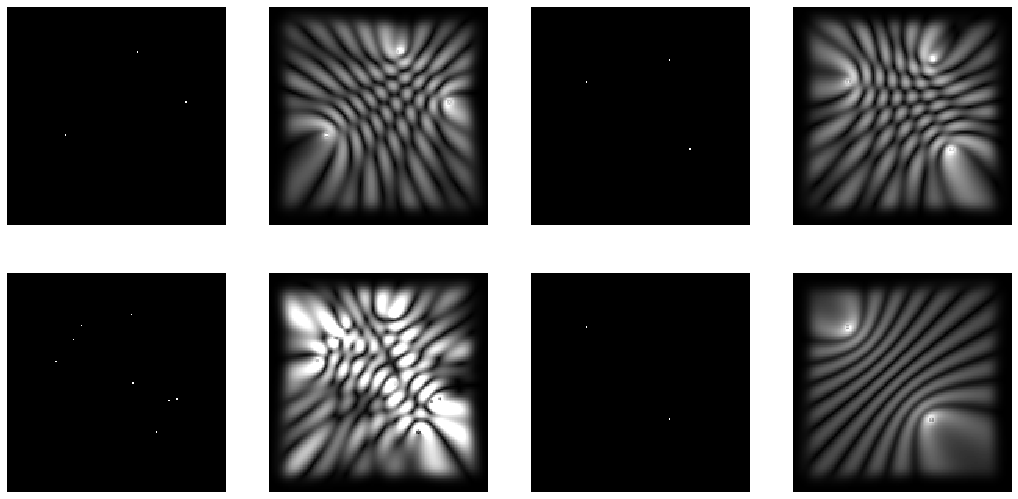

In [0]:
dbunch.train_dl.show_batch(max_n=4, figsize=(18,9), cmap='gray')

In [0]:
learn = unet_learner(dbunch, resnet34, loss_func=nn.MSELoss(), metrics=[rmse, mae], pretrained=True,#nn.MSELoss()
                    config=unet_config(norm_type=NormType.InstanceZero)) # gave great results with defualt unet config. tweak it around a bit...

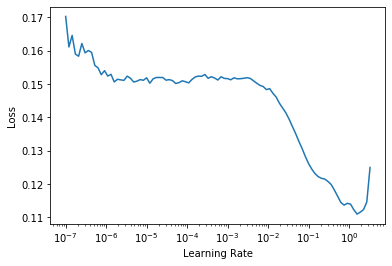

In [0]:
# learn.unfreeze()
learn.lr_find()

In [0]:
lr = 1e-1
wd = 1e-4

In [0]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.3):
    learn.fit_one_cycle(8, lrs, pct_start=pct_start, wd=wd)
    # learn.save(save_name)
    learn.show_results(ds_idx=1, max_n=5, figsize=(15,11), cmap='gray')

epoch,train_loss,valid_loss,_rmse,mae,time
0,0.066146,0.046086,0.214676,0.172780,00:11
1,0.042132,0.032148,0.179298,0.129814,00:08
2,0.035688,0.031689,0.178014,0.126341,00:08
3,0.033417,0.032822,0.181167,0.127387,00:08
4,0.032679,0.032037,0.178988,0.131076,00:08
5,0.032045,0.031105,0.176367,0.124647,00:08
6,0.031559,0.031007,0.176087,0.124008,00:08
7,0.031456,0.030785,0.175456,0.124083,00:08


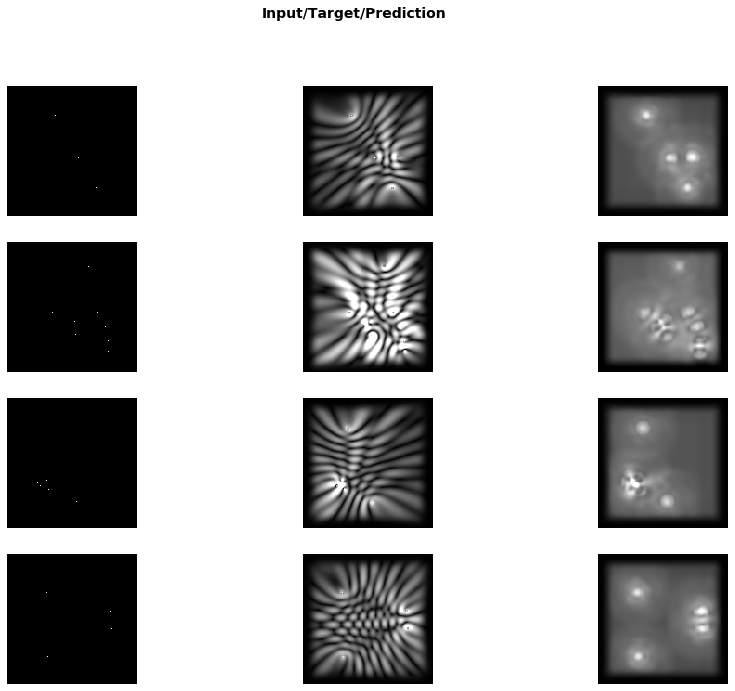

In [0]:
do_fit('2a', lr)

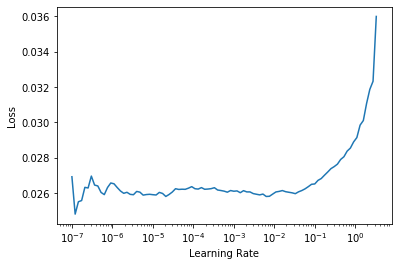

In [0]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,_rmse,mae,time
0,0.023277,0.023147,0.152140,0.108430,00:09
1,0.023292,0.023246,0.152465,0.108738,00:09
2,0.023488,0.023365,0.152858,0.109345,00:09
3,0.023359,0.023236,0.152435,0.108470,00:09
4,0.023367,0.023167,0.152207,0.108403,00:09
5,0.023261,0.023095,0.151971,0.108378,00:09
6,0.023175,0.023080,0.151921,0.108301,00:09
7,0.023076,0.023065,0.151872,0.108288,00:09


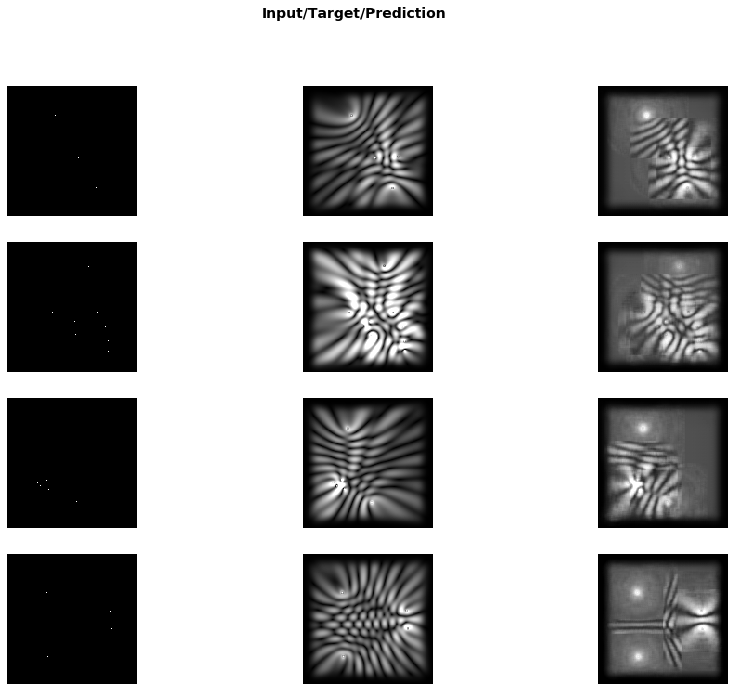

In [0]:
do_fit('2a', slice(2e-3))

In [0]:
%%timeit
lol = learn.predict(learn.dbunch.valid_ds.items[3])
# pp = lol[0].numpy().squeeze()

10 loops, best of 3: 145 ms per loop


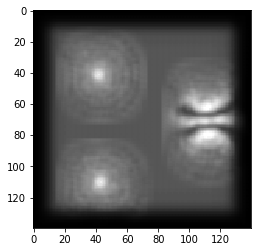

In [0]:
s = plt.imshow(pp, cmap='gray')

In [0]:
lol = s.to_rgba(pp)
lol = (lol*255).astype(np.uint8)
from PIL import Image as PImg
im = PImg.fromarray(lol[:, :, 0:3])
im.save("im1.png")

In [0]:
dbunch.valid_ds.items[3]

Path('train/x/train_0094.png')

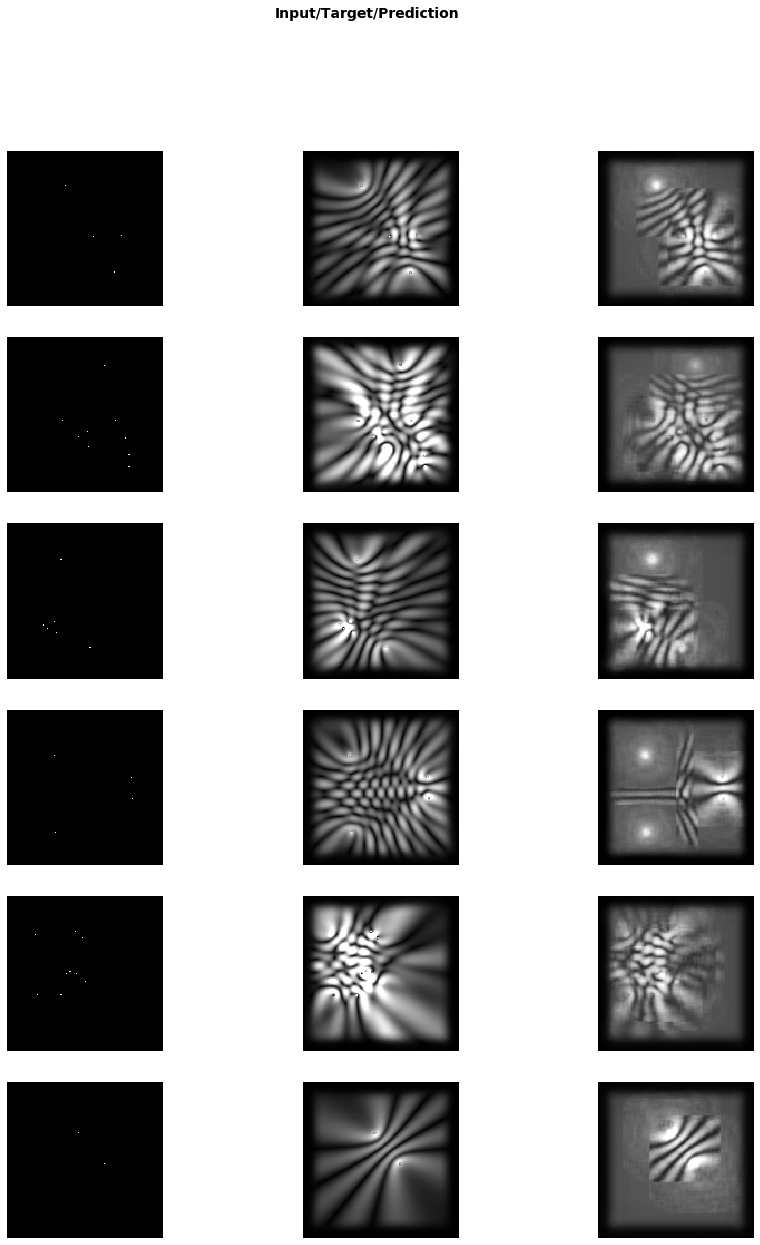

In [0]:
learn.show_results(ds_idx=1, max_n=10, figsize=(15,20), cmap='gray')